In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np

In [3]:
df_mini1 = pd.read_pickle("with/spec1_1000.pickle")
df_mini2 = pd.read_pickle("with/spec1_2000.pickle")
df_mini3 = pd.read_pickle("with/spec1_3000.pickle")

In [4]:
df_one = df_mini1 + df_mini2 + df_mini3

In [5]:
# label
df_one[0][1]

1

In [6]:
df_no_mini1 = pd.read_pickle("without/spec0_1000.pickle")
df_no_mini2 = pd.read_pickle("without/spec0_2000.pickle")
df_no_mini3 = pd.read_pickle("without/spec0_3000.pickle")

In [7]:
df_no = df_no_mini1 + df_no_mini2 + df_no_mini3

In [8]:
# label
df_no[0][1]

0

In [9]:
def load_data():
    data = []
    labels = []
    
    for i in df_one:
        datapoint = i[0]
        data.append(datapoint)
        
        label = i[1]
        labels.append(label)
        
    for j in df_no:
        datapoint = j[0]
        data.append(datapoint)
        
        label = j[1]
        labels.append(label)
        
        
    return(np.array(data), np.array(labels))        
        

In [10]:
(data, labels) = load_data()
data = np.array(data, dtype=np.float32) 

In [11]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(rescale=1.0/255.0)
data = datagen.standardize(data)

In [12]:
data[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [13]:
labels[0]

1

In [14]:
y = []
for i in range(len(labels)):
    # if (labels[i]=="null"):
    #     y.append([1,0,0])
    if(labels[i]==1):
        y.append([1,0])
    elif(labels[i]==0):
        y.append([0,1])  

In [15]:
y[0]

[1, 0]

In [16]:
y = np.array(y)

In [17]:
data.shape

(6000, 288, 432, 3)

In [18]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(data, y, test_size=0.2, random_state=42)

In [19]:
# trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [20]:
trainX.shape

(4800, 288, 432, 3)

In [21]:
def top_1_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=1)

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

In [23]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [24]:
# width - width of the input image
# height - height of the input image OR number of rows
# depth - number of channels in the input image
# initialize the model along with input shape to be 
# 'channel last'
model = Sequential()
inputShape = (288, 432, 3)
# chanDim - the index of the channel dimension
# channel is depth, whose index is -1
chanDim = -1 


# first CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# secons CONV => RELU => CONV => RELU => POOL layer set
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(2))
model.add(Activation("softmax"))

In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# H = model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=5, verbose=1, validation_split=0.1)
H = model.fit(trainX, trainY, batch_size=8, epochs=20, verbose=1, validation_split=0.1)

Train on 4320 samples, validate on 480 samples
Epoch 1/20
4320/4320 [==============================] - 52s 12ms/sample - loss: 0.7861 - accuracy: 0.6157 - val_loss: 1.3287 - val_accuracy: 0.6438
Epoch 2/20
4320/4320 [==============================] - 50s 12ms/sample - loss: 0.6573 - accuracy: 0.6829 - val_loss: 0.5825 - val_accuracy: 0.6812
Epoch 3/20
4320/4320 [==============================] - 51s 12ms/sample - loss: 0.5628 - accuracy: 0.7449 - val_loss: 0.4745 - val_accuracy: 0.7688
Epoch 4/20
4320/4320 [==============================] - 51s 12ms/sample - loss: 0.5211 - accuracy: 0.7630 - val_loss: 0.4555 - val_accuracy: 0.7854
Epoch 5/20
4320/4320 [==============================] - 51s 12ms/sample - loss: 0.4976 - accuracy: 0.7856 - val_loss: 0.3969 - val_accuracy: 0.8687
Epoch 6/20
4320/4320 [==============================] - 51s 12ms/sample - loss: 0.5025 - accuracy: 0.7722 - val_loss: 5.6669 - val_accuracy: 0.5708
Epoch 7/20
4320/4320 [==============================] - 51s 12ms/

In [26]:
# evaluation using keras
results = model.evaluate(testX, testY, batch_size=8)
print(model.metrics_names)
print(results)

1200/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

['loss', 'accuracy']
[0.4950791519818207, 0.87916666]


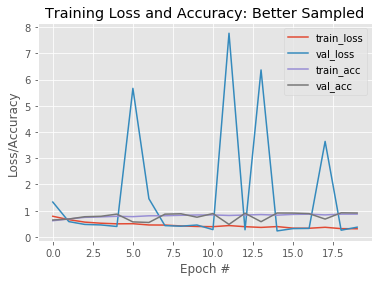

In [27]:
# plot the training loss and accuracy
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy: Better Sampled")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("Better_Sampled_25epoch_VGG-Netv3.png")
plt.show()

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 288, 432, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 288, 432, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 288, 432, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 288, 432, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 288, 432, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 288, 432, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 144, 216, 32)      0

In [29]:
model.save("Better_Sampled_25epoch_VGG-Netv3.h5")